# Pytorch Example Problem

- We will build our first regression problem on the California housing dataset. The dataset contains the house prizes (median within a block) in California from the 1990 census together with some parameters of the housing block. The machine learning task will be to predict the median house value based on the other parameters, which thus serve as features

- Before we dive into `Pytorch` - here are some helpful tutorials:
    - `Introduction`: https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html, https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html
    - `Training`: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html, https://pytorch.org/tutorials/beginner/pytorch_with_examples.html, https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
    - `Datasets, Dataloaders`: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    - `Layer`:  https://pytorch.org/docs/stable/nn.html
    - `Loss`: https://pytorch.org/docs/stable/nn.html#loss-functions
    - `Optimizers`: https://pytorch.org/docs/stable/optim.html

- California Housing Dataset: Information concerning the demography (income, population, house occupancy) in the respective districts, together with the location of the districts (latitude, longitude), and additional general kn regarding the house in the districts (number of rooms and bedrooms, age of the house). These statistics are based on a specific district, why they are reported as average or median values.
  
    - Use the `housing.csv` file (available here: https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html or https://www.kaggle.com/datasets/camnugent/california-housing-prices?select=housing.csv)
    - See also the short description(s) (here: https://www.kaggle.com/datasets/camnugent/california-housing-prices?select=housing.csv and https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)

- Get familiar with `Pytorch datasets` and `dataloaders`: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Do some exploratory data analysis (`descriptive statistics`) on the dataset (`histogram` of every column, `correlation`, `scatter-matrix`)

- Prepare your dataset for machine learning. You will define a `Neural Network` in `Pytorch`, please create appropriate `PyTorch` `datasets` and `dataloaders`

## Exploratory Data Analysis
- Read in `housing.csv` via `pandas` and ignore/remove the last column (`ocean_proximity`) for further processing
- Create `histogram` information for each column
- Check for `NaN, None, NaT` values in the entire data corpus and remove data entries which are affected
- Compute pairwise correlation of columns via `corr()`
- Create a `scatter-matrix` - Interpret the results! What can be observed, e.g. population size and number of bedrooms - Interpret the results!
- Create individual `column`-specific `scatter` plots (`x-axis` = number of data samples, `y-axis` = value range) - Interpret the results!

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('housing.csv')
df.head()

,Longitude,Latitude,HousingMedianAge,TotalRooms,TotalBedrooms,Population,Households,MedianIncome,MedianHouseValue
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


<function matplotlib.pyplot.show(close=None, block=None)>

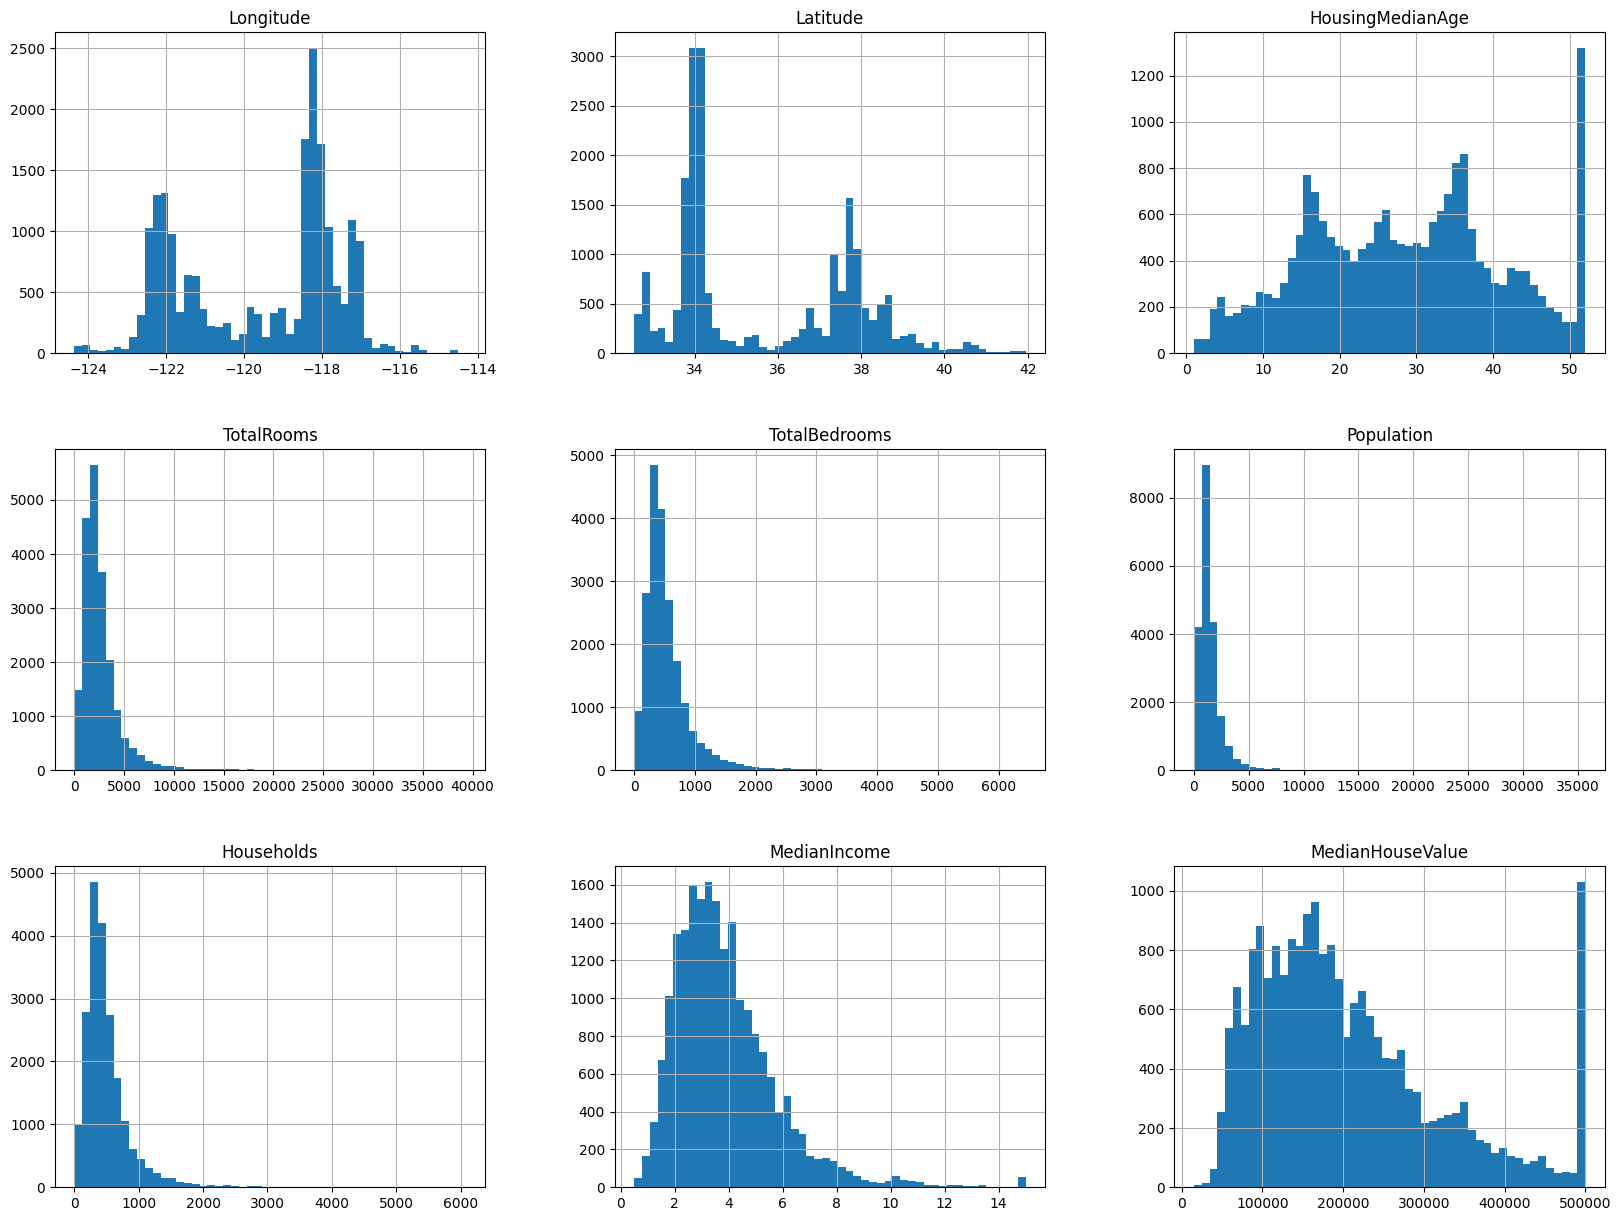

In [18]:
df.hist(bins=50, figsize=(20,15))
plt.show

In [19]:
df = df.dropna()

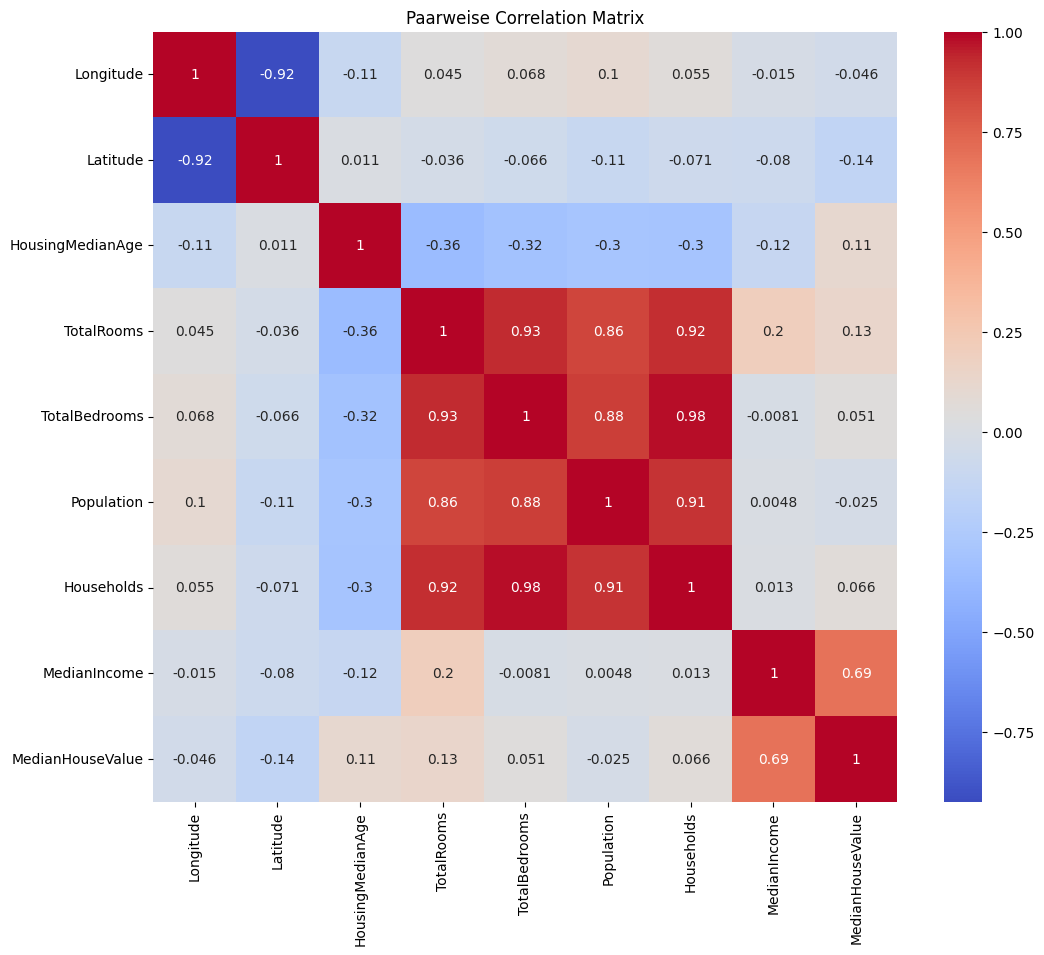

In [20]:
correlation_matrix = df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Paarweise Correlation Matrix")
plt.show()

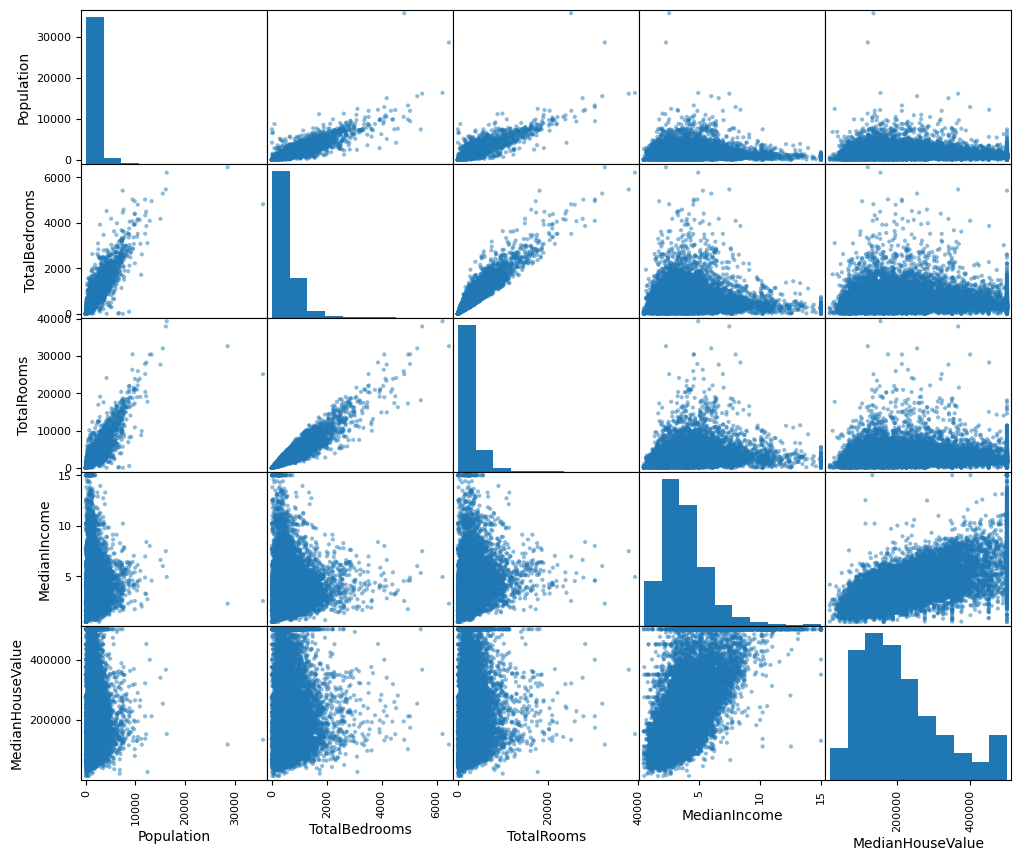

In [21]:
selected_columns=['Population', 'TotalBedrooms', 'TotalRooms', 'MedianIncome', 'MedianHouseValue']
pd.plotting.scatter_matrix(df[selected_columns], figsize=(12,10))
plt.show()

## Model Prediction
- **Major Goal:** predicting house values (`MedianHouseValue`) based on all the other given `variables/features` (`Longitude, Latitude, HousingMedianAge, TotalRooms, TotalBedrooms, Population, Households, MedianIncome`)

### Prepare Data: Create Datasets and Dataloaders

- Split your data into `training`, `validation`, and `test` via the `PyTorch` function `train_test_split`

In [22]:
from sklearn.model_selection import train_test_split

#ground truth vs. features
ycol = 'MedianHouseValue'
X = df.drop(columns=[ycol])
y = df[ycol]

#train - test
Xtr_, Xte, ytr_, yte = train_test_split(X, y, test_size=0.1, random_state=42)

#train - validation
Xtr, Xval, ytr, yval = train_test_split(Xtr_, ytr_, test_size=0.2, random_state=43)

- Build your own `Custom Dataset` (inherit `from torch.utils.data import Dataset`)
- Provide an option (`scalers`) to normalize your data (`max val=1` and `min val=0`) - Use `MiinMaxScaler` of `sklearn.preprocessing`
- Provide also two additional options including `transform` and `target_transform`, representing a list of sequentially applied functions in order to compute different types of user-specific transformations (e.g. `transform = [functionA(paraA,...), functionB(paraB,...), functionB(paraC,...), etc.]`)
- Implement/Overwrite the system call methods (`magic methods`) of `__len__` and `__getitem__` - Which operations trigger an underlying function call of those methods?

In [67]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler

In [25]:
class MyCustomDataset(Dataset):
    def __init__(self, X, y, scalers=None, scale=True, transform=None, target_transform=None):
        if scale:
            if scalers is None:
                self.mmX = MinMaxScaler()
                self.mmy = MinMaxScaler()
                _X = self.mmX.fit_transform(X.values)
                _y = self.mmy.fit_transform(y.values.reshape(-1, 1))
            else:
                self.mmX = scalers[0]
                self.mmy = scalers[1]
                _X = self.mmX.transform(X.values)
                _y = self.mmy.transform(y.values.reshape(-1, 1))
        else:
            # no scaling
            _X = X.values
            _y = y.values
            
        self.X = torch.from_numpy(_X).to(torch.float32)
        self.y = torch.from_numpy(_y).to(torch.float32)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx,:]
        target = self.y[idx]
        
        return features, target
    
    def get_scalers(self):
        return self.mmX, self.mmy

- Instantiate your `training, validation, and testing` dataset by calling the constructor of `MyCustomDataset` (`scale=True`, `scalers=None` only for `training` dataset)
- Get and store both scalers `min/max` of the `training set` in two variables (for later processing) and use them for the `scalers` option of your validation and test set
- Report the size of a single input feature vector `x` as well as output feature vector `y`
- Report the overall size of your `training, validation, and test dataset`

In [29]:
dataset = MyCustomDataset(Xtr,ytr, scalers=None, scale=True)

In [30]:
tr_min_scaler, tr_max_scaler = dataset.get_scalers()

In [32]:
feature, target = dataset.__getitem__(0)
print(f"Feature: {feature}")
print(f"Target: {target}")

Feature: tensor([0.3875, 0.2234, 0.1765, 0.0545, 0.0953, 0.0326, 0.1021, 0.1091])
Target: tensor([0.1821])


In [34]:
print(f"Anzahl Trainingsdaten: {len(Xtr)}")
print(f"Anzahl Testdaten: {len(Xte)}")
print(f"Anzahl Validierungsdaten: {len(Xval)}")

Anzahl Trainingsdaten: 14860
Anzahl Testdaten: 2064
Anzahl Validierungsdaten: 3716


- Use the partition-specific `datasets` (`MyCustomDataset`) to build the corresponding `dataloaders` via `from torch.utils.data import DataLoader`
- Choose a `batch-size` of `16` for `training, validation, and test`, together with the `shuffle=True` option

In [41]:
from torch.utils.data import DataLoader

train_dataset = MyCustomDataset(Xtr, ytr)
validation_dataset = MyCustomDataset(Xval, yval)
test_dataset = MyCustomDataset(Xte, yte)

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

## Baseline System - Random Forest Regressor

- Create a `RandomForestRegressor` using `sklearn.ensemble` (`n_estimators=100`) - Check the `Python` documentation what is addressed by the parameter `n_estimators`!
- Train the `RandomForestRegressor` using your `training dataset` (seperate it first into `input feature list` and `ground truth list`)
- Validate/Test the `RandomForestRegressor` using your `validation dataset` and `test dataset` (seperate it first into `input feature list` and `ground truth list`) - compute `inverse transform` before!
- Careful: use the `min-max-scaler` to compute an `inverse_transform` of the `0/1-min-max` normalized values back to its original values before computing the final target metrics. Why re-transform?
- Report the `r2_score` and `root mean squarred error` (`RMSE`) from the `sklearn_metrics` package

In [37]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)

#train
XX, yy = train_dataset[:]

rf.fit(np.array(XX), np.array(yy).ravel())

#predict
XXv, yyv = validation_dataset[:]
XXt, yyt = test_dataset[:]

yval_pred_rf = rf.predict(XXv.numpy())
ytest_pred_rf = rf.predict(XXt.numpy())

mmx, mmy = train_dataset.get_scalers()
#evaluate val
ypredv_rf = (mmy.inverse_transform(yval_pred_rf.reshape(-1, 1)).tolist())
ypredv_rf = np.array(ypredv_rf).ravel()             

ytruev_rf = (mmy.inverse_transform(yyv.numpy().reshape(-1, 1)).tolist())
ytruev_rf = np.array(ytruev_rf).ravel()

#evaluate test
ypredt_rf = (mmy.inverse_transform(ytest_pred_rf.reshape(-1, 1)).tolist())
ypredt_rf = np.array(ypredt_rf).ravel()             

ytruet_rf = (mmy.inverse_transform(yyt.numpy().reshape(-1, 1)).tolist())
ytruet_rf = np.array(ytruet_rf).ravel()

In [38]:
from sklearn.metrics import r2_score, mean_squared_error
print("-------------------------------------------------------------------------------")
print ("Baseline System Random Forest Classifier (Validation Set):")
print("-------------------------------------------------------------------------------")
print ("R2 Random Forest", r2_score(ytruev_rf, ypredv_rf))
print ("RMSE Random Forest", mean_squared_error(ytruev_rf, ypredv_rf, squared=False))
print()
print("-------------------------------------------------------------------------------")
print ("Baseline System Random Forest Classifier (Test Set):")
print("-------------------------------------------------------------------------------")
print ("R2 Random Forest", r2_score(ytruet_rf, ypredt_rf))
print ("RMSE Random Forest", mean_squared_error(ytruet_rf, ypredt_rf, squared=False))

-------------------------------------------------------------------------------
Baseline System Random Forest Classifier (Validation Set):
-------------------------------------------------------------------------------
R2 Random Forest 0.7244741783884114
RMSE Random Forest 62042.67136217003

-------------------------------------------------------------------------------
Baseline System Random Forest Classifier (Test Set):
-------------------------------------------------------------------------------
R2 Random Forest 0.6711256951338754
RMSE Random Forest 68339.85152917726


## Neural Network Design

- Design a neural network for this regression task. Familiarize with the key concepts and how these are implemented in Pytorch (see links for documentation and tutorials at the very beginning):
    - Network and layers
    - Nonlinearity (ReLU)
    - Training and validation datasets
    - Optimizer
    - Loss function 

- Build a `CHNetwork` which inherits from `nn.Module` of `torch`
- Defined and implement the `__init__` (constructor) and the `forward path`
- Create a `MLP` (Multi-Layer-Perceptron) with an `input layer`, two `hidden layer`, and an `output layer` with the following dimensional relations/number of neurons: `8 to 512`, `512 to 64`, and `64 to 1`
- After every of those `fully-connected` layer (except the last one, which projects the hidden representation to the final output neuron) a `ReLU` activation function is applied
- Return the final and overall `feature output x` 

In [39]:
import torch
import torch.nn as nn

class CHNetwork(nn.Module):  # inheriting from nn.Module!

    def __init__(self, input_size, output_size):
        super(CHNetwork, self).__init__()

        hidden_size = [512, 64]

        self.linear01 = nn.Linear(input_size, hidden_size[0])
        self.linear02 = nn.Linear(hidden_size[0], hidden_size[1])
        self.linear03 = nn.Linear(hidden_size[1], output_size)
        

    def forward(self, input):
        x = torch.relu(self.linear01(input))
        x = torch.relu(self.linear02(x))
        x = self.linear03(x)

        return x

## Training Routine Design

- Implement an entire network training routine, including all of the required parametric options, such as:
    - `_net` - Neural network model
    - `_optimizer_fn`- Type of Optimizer
    - `optim_params` - Parameter of Optimizer (learning rate, beta values, ...)
    - `_scheduler_fn` - Scheduler for learning rate
    - `scheduler_params` - Parameter of Scheduler (learning rate decay gamma, step-size for learning rate patience, verbose, ...)  
    - `_loss_fn` - Loss Function
    - `dataloader_tr` - Dataloader for training set
    - `dataloader_val` - Dataloader for validation set
    - `epochs`- Maximum number of training epochs
    - `apply_scheduler` - Use learning rate scheduling
    - `snapshot_inverval` - Number of epochs 
    - `snap_path` - Path where to store snapshots

In [42]:
import os

"""
Routine to train the neural network.
Args:
    - _net - Neural network model
    - _optimizer_fn- Type of Optimizer (torch.optim function)
    - optim_params - Parameter of Optimizer (learning rate, beta values, ...)
    - _scheduler_fn - Scheduler for learning rate
    - scheduler_params - Parameter of Scheduler (learning rate decay gamma, step-size for learning rate patience, verbose, ...)  
    - _loss_fn - Loss Function (torch.nn loss)
    - dataloader_tr - Dataloader for training set
    - dataloader_val - Dataloader for validation set
    - epochs - Maximum number of training epochs
    - apply_scheduler (default: True) - Use learning rate scheduling
    - snapshot_inverval (default: 300) - Number of epochs 
    - snap_path (default "./") - Path where to store snapshots
"""

def training(_net, 
             _optimizer_fn, 
             optim_params, 
             _scheduler_fn,
             scheduler_params,
             _loss_fn, 
             dataloader_tr, 
             dataloader_val, 
             epochs,
             apply_scheduler=True,
             snapshot_interval=300,
             snap_path = "./"):
 
    _optimizer = _optimizer_fn(_net.parameters(), **optim_params)
    _scheduler = _scheduler_fn(_optimizer, **scheduler_params)
    
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(epochs)):
        
        _net.train()
        running_tr_loss = 0
        
        for i, data in enumerate(dataloader_tr):

            _optimizer.zero_grad()
            
            inputs, targets = data
            
            yhats = _net(inputs)
            
            loss = _loss_fn(yhats, targets)
            loss.backward()
            _optimizer.step()
            
            if apply_scheduler:
                _scheduler.step()
            
            running_tr_loss += loss.detach().numpy()
            
        running_tr_loss /= (i+1)

        train_losses.append(running_tr_loss)
        print("Training loss: ", running_tr_loss)
        
        running_val_loss = 0        
        _net.eval()
        
        with torch.no_grad():
            
            for i, vdata in enumerate(dataloader_val):
                vinputs, vtargets = vdata
                vloss = _loss_fn(_net(vinputs), vtargets)
                running_val_loss += vloss.detach().numpy()
            
            running_val_loss /= (i+1)
            val_losses.append(running_val_loss)

            print("Validation loss: ", running_val_loss)
            
        if epoch % snapshot_interval == 0:
            filename = "snapshot_%s" % (int(epoch/snapshot_interval))
            torch.save(_net.state_dict().copy(), os.path.join(snap_path, filename))


    return train_losses, val_losses

- Train your neural network and evaluate its performance on the validation set by calling the designed training routine `training`
- Get the `number of input features` (size of the input layer)
- Create a new model (`CHNetwork`) with the respective `input` and `output features size`
- Create a loss function (optimization criterion), using `torch.nn`. Use the existing `MSELoss` with the `reduction` option `mean`
- Create a `SGD` optimizer from `torch.optim`
- Create a `Exponential Learning Rate Scheduler` using `torch.optim`
- Define the `parameters` as a dictionary for the `optimizer` (initial `learning rate` of `0.1`) and `scheduler` (`gamma` of `0.99999` and `verbose` not activated)
- Set the `maximum` number of `training epochs` to `500` (try also different values!)
- Call the `training` method (training routine) with all the defined parameters 

In [ ]:
#number of input features
number_of_features = X.values.shape[1]

#network
my_net_def = CHNetwork(number_of_features, 1)

#loss function
my_loss_fn = nn.MSELoss(reduction = 'mean')

#optimizer
my_optimizer_fn = torch.optim.SGD

#scheduler
my_scheduler_fn = torch.optim.lr_scheduler.ExponentialLR

#params
optim_params = {
        'lr': 0.1
}

scheduler_params = {
        'gamma': 0.99999,
        'verbose': False,
}

#training epochs maximum
epochs_max = 500

train_losses_ref, val_losses_ref = training(my_net_def, 
                                          my_optimizer_fn, 
                                          optim_params, 
                                          my_scheduler_fn,
                                          scheduler_params,
                                          my_loss_fn, 
                                          train_dataloader, 
                                          validation_dataloader, 
                                          epochs_max,
                                          apply_scheduler=True)


## Evaluation and Interpretation

- Define a function `get_metrics` using the model together with a given data partition to compute and return the `R2` and `RMSE`
- Predict the `MedianHouseValue` for each sample (`feature vector x`) in the data partition (accumulate the `model output (prediction)` and `ground truth` for the entire dataset)
- Careful: compute the `inverse_transform` using the `min-max-scaler` before accumlating `prediction` and `ground truth`
- Compute/Return `R2` and `RMSE` based on the inverse transformed min-max prediction `ypred` and ground truth `ytrue`
- Interpret the individual metrics - What is a `R2-Score` and `RMSE` and how the metric should change in order to improve the model quality?

In [44]:
def get_metrics(net, validation_dataloader):
    ytrue = []
    ypred = []
    net.eval()
    for i, vdata in enumerate(validation_dataloader):
        vinputs, vtargets = vdata
        preds = net(vinputs)

        ytrue += (mmy.inverse_transform(vtargets).tolist())
        ypred += (mmy.inverse_transform(preds.detach().numpy()).tolist())

    ytrue = np.array(ytrue).ravel()
    ypred = np.array(ypred).ravel()

    r2 = r2_score(ytrue, ypred)
    rmse = mean_squared_error(ytrue, ypred, squared=False)

    return r2, rmse

- Plot the training loss (`line plot`) using the final and overall `train loss` across all `epochs` from your training routine (`training`)
- Plot the validation loss (`line plot`) in exactly the same way (using the `validation loss`)
- Plot the validation loss (`line plot`) by computing the average across `n=10` windowed validation values (smoothing) via `pandas Series rolling`
- Call the `get_metrics` function, using your trained model, in order to compute the `R2` and `RMSE` metrics (validaton and test). Compare it with the `Random Forest Regressor` result!

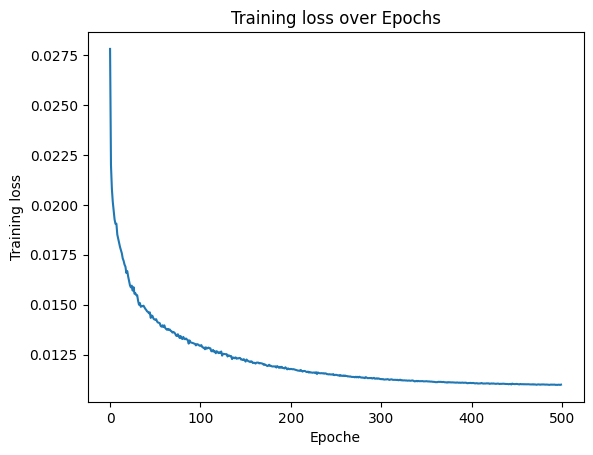

In [51]:
fig, ax = plt.subplots()
ax.plot(train_losses_ref)
ax.set_title('Training loss over Epochs')
ax.set_xlabel('Epoche')
ax.set_ylabel('Training loss')
plt.show()

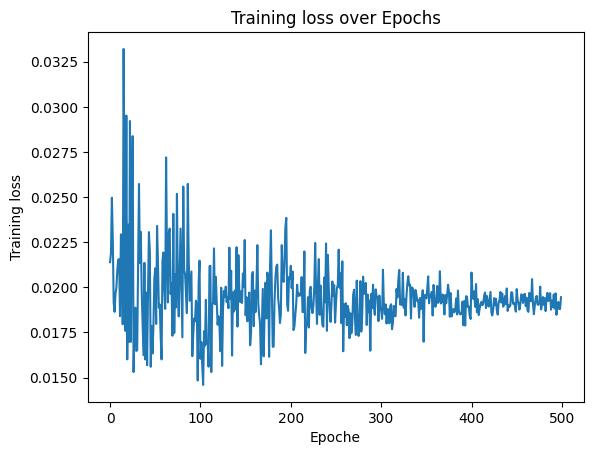

In [52]:
fig2, ax = plt.subplots()
ax.plot(val_losses_ref)
ax.set_title('Training loss over Epochs')
ax.set_xlabel('Epoche')
ax.set_ylabel('Training loss')
plt.show()

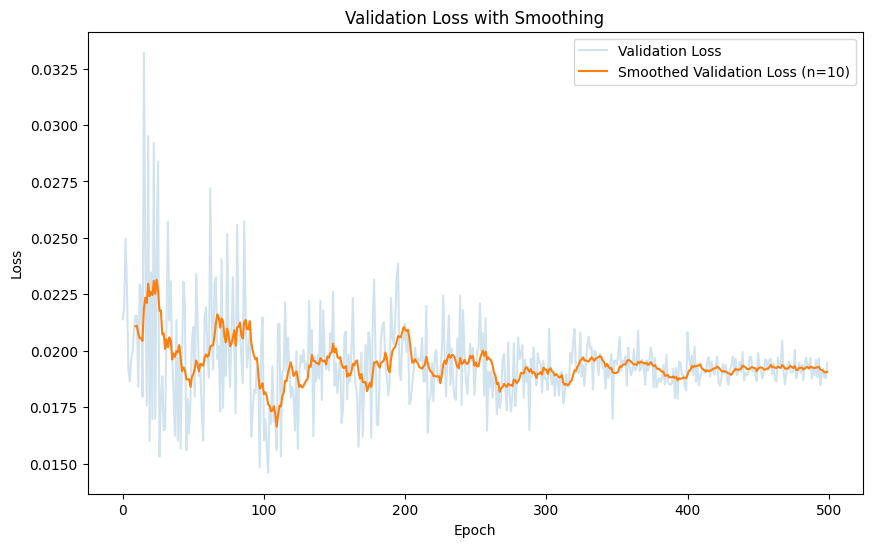

In [54]:
# Create a pandas Series from the validation loss values
validation_loss_series = pd.Series(val_losses_ref)

# Compute the rolling mean with a window size of n=10
rolling_mean = validation_loss_series.rolling(window=10).mean()

# Plot the original validation loss and the smoothed curve
plt.figure(figsize=(10, 6))
plt.plot(validation_loss_series, label='Validation Loss', alpha=0.2)
plt.plot(rolling_mean, label='Smoothed Validation Loss (n=10)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss with Smoothing')
plt.show()

In [60]:
r2, rmse = get_metrics(my_net_def, validation_dataloader)
print(f'R2 auf Validation Dataset: {r2}')
print(f'RMSE auf Validation Dataset: {rmse}')

R2 auf Validation Dataset: 0.6727950531724676
RMSE auf Validation Dataset: 67611.29735103031


In [61]:
r2, rmse = get_metrics(my_net_def, test_dataloader)
print(f'R2 auf Validation Dataset: {r2}')
print(f'RMSE auf Validation Dataset: {rmse}')

R2 auf Validation Dataset: 0.2413961304722706
RMSE auf Validation Dataset: 103792.64772531904


In [62]:
print ("R2 Random Forest", r2_score(ytruet_rf, ypredt_rf))
print ("RMSE Random Forest", mean_squared_error(ytruet_rf, ypredt_rf, squared=False))

R2 Random Forest 0.6711256951338754
RMSE Random Forest 68339.85152917726


## Neural Network Improvements and Fine-Tuning:
Try to improve your initial neural network performance by adding additional techniques and perform manual hyperparameter tuning:

- Try different layer architectures (deeper networks)
- Different Optimizers (e.g. `SGD` with `momentum`,  `RMSProp`, `Adam`)
- Early Stopping
- Dropout

**Important:** Once you have realized the additional code extension you can use the above training routine (`training`) to start a new training of your network, together with all the changes. Afterwards you can use the same plotting and metric computation (`get_metrics`) for all the different network alternatives/options.

### Deeper Nerual Network Architecture

Change your initial `CHNetwork` implementation (deeper network and more parameters) to realize the following architectural design:
- Model Design: `Input Layer`, `3x Hidden Layer`, `Output Layer` (use `nn.Linear` ase in the example above)
- Layer Shapes: `8 to 512`, `512 to 256`, `256 to 128`, `128 to 64`, `64 to 1`
- Activation Functions: `relu` activation after each layer, except the final output layer
- Implement the `__init__` and `forward` function (see example above)
- Return `x`
- Train your model again and report the individual loss plots plus the `R2` and `RMSE`
- **Additional Remark**: of course you can also try different architectural designs and activation functions - play around!

In [74]:
import torch
import torch.nn as nn

class CHNetwork(nn.Module):  # inheriting from nn.Module!

    def __init__(self, input_size, output_size):
        super(CHNetwork, self).__init__()
        hidden_size = [512, 256,128, 64]
        
        self.linear01 = nn.Linear(input_size, hidden_size[0])
        self.linear02 = nn.Linear(hidden_size[0], hidden_size[1])
        self.linear03 = nn.Linear(hidden_size[1], hidden_size[2])
        self.linear04 = nn.Linear(hidden_size[2], hidden_size[3])
        self.linear05 = nn.Linear(hidden_size[3], output_size)

    def forward(self, input):
        x = torch.relu(self.linear01(input))
        x = torch.relu(self.linear02(x))
        x = torch.relu(self.linear03(x))
        x = torch.relu(self.linear04(x))
        x = self.linear05(x)
        return x

In [ ]:
#number of input features
number_of_features = X.values.shape[1]

#network
my_net_def2 = CHNetwork(number_of_features, 1).to()

#loss function
my_loss_fn = nn.MSELoss(reduction = 'mean')

#optimizer
my_optimizer_fn = torch.optim.SGD

#scheduler
my_scheduler_fn = torch.optim.lr_scheduler.ExponentialLR

#params
optim_params = {
        'lr': 0.1
}

scheduler_params = {
        'gamma': 0.99999,
        'verbose': False,
}

#training epochs maximum
epochs_max = 500

train_losses_ref, val_losses_ref = training(my_net_def, 
                                          my_optimizer_fn, 
                                          optim_params, 
                                          my_scheduler_fn,
                                          scheduler_params,
                                          my_loss_fn, 
                                          train_dataloader, 
                                          validation_dataloader, 
                                          epochs_max,
                                          apply_scheduler=True)


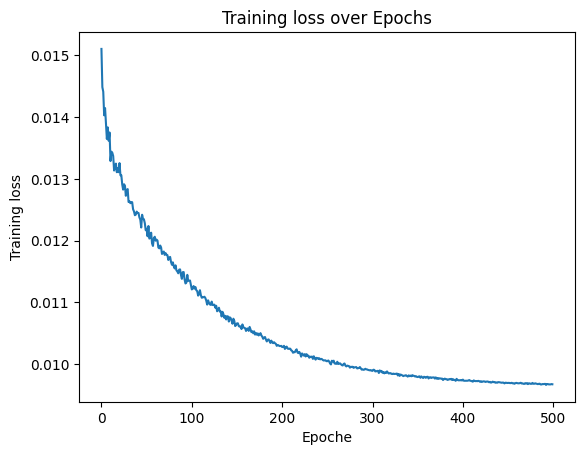

In [77]:
fig, ax = plt.subplots()
ax.plot(train_losses_ref)
ax.set_title('Training loss over Epochs')
ax.set_xlabel('Epoche')
ax.set_ylabel('Training loss')
plt.show()

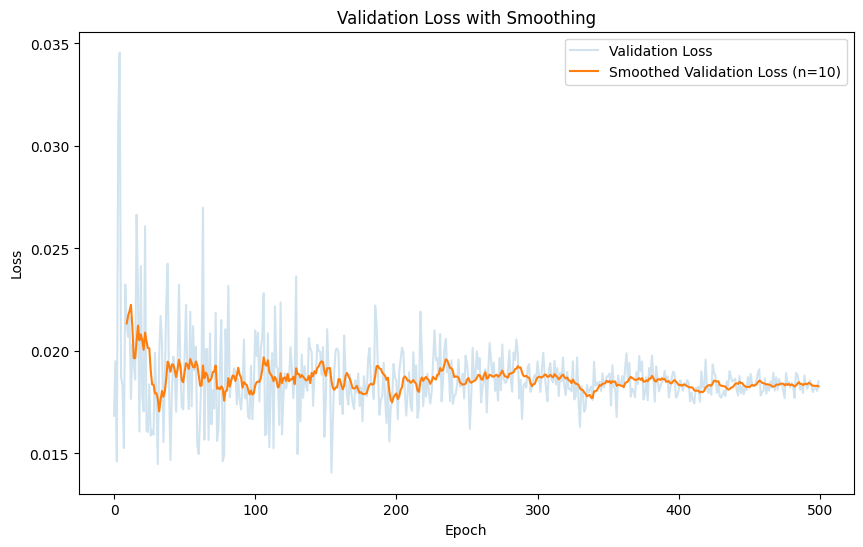

In [78]:
# Create a pandas Series from the validation loss values
validation_loss_series = pd.Series(val_losses_ref)

# Compute the rolling mean with a window size of n=10
rolling_mean = validation_loss_series.rolling(window=10).mean()

# Plot the original validation loss and the smoothed curve
plt.figure(figsize=(10, 6))
plt.plot(validation_loss_series, label='Validation Loss', alpha=0.2)
plt.plot(rolling_mean, label='Smoothed Validation Loss (n=10)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss with Smoothing')
plt.show()

In [79]:
plt.show()
r2, rmse = get_metrics(my_net_def, validation_dataloader)
print(f'R2 auf Validation Dataset: {r2}')
print(f'RMSE auf Validation Dataset: {rmse}')

R2 auf Validation Dataset: 0.6874509661659681
RMSE auf Validation Dataset: 66079.75427395289


In [80]:
r2, rmse = get_metrics(my_net_def, test_dataloader)
print(f'R2 auf Validation Dataset: {r2}')
print(f'RMSE auf Validation Dataset: {rmse}')

R2 auf Validation Dataset: 0.26500845920199745
RMSE auf Validation Dataset: 102164.55186976415


### Different Optimizer

- Different Optimizers, e.g. `SGD` with `Momentum`,  `RMSProp`, `Adam` and/or hyperparameter options (e.g. `momentum`, etc.)
- Hyperparamter tuning: in practice iterate across the full range of meaningful momentum values to identify the best fitting one
- Using the `SGD` optimizer with momentum
- Train your model again and report the individual loss plots plus the `R2` and `RMSE`
- **Additional Remark**: of course you can also try different opimizers and/or parametric variations - play around!

In [ ]:
#number of input features
number_of_features = X.values.shape[1]

#network
my_net_def3 = CHNetwork(number_of_features, 1)

#loss function
my_loss_fn = nn.MSELoss(reduction = 'mean')

#optimizer
my_optimizer_fn = torch.optim.SGD(momentum=0.01)

#scheduler
my_scheduler_fn = torch.optim.lr_scheduler.ExponentialLR

#params
optim_params = {
        'lr': 0.1
}

scheduler_params = {
        'gamma': 0.99999,
        'verbose': False,
}

#training epochs maximum
epochs_max = 500

train_losses_ref, val_losses_ref = training(my_net_def, 
                                          my_optimizer_fn, 
                                          optim_params, 
                                          my_scheduler_fn,
                                          scheduler_params,
                                          my_loss_fn, 
                                          train_dataloader, 
                                          validation_dataloader, 
                                          epochs_max,
                                          apply_scheduler=True)


### Early Stopping

- Get yourself familiar with `early stopping` in neural networks
  
Build your own `EarlyStoppingCriterion` by implementing the code skeleton below:
- The constructor gets three different argurments as input:
    - `patience` - the number of epochs after the model stops training in case there was no improvement on the validation loss
    - `mode` - distinguish between two possible types: `min` (minimization of your target metric, e.g. loss) and `max` (maximizing your target metric, e.g. accuracy)
    - `min_delta (default: 0)` - provide the option for a `min_delta` (minimum value) the new/updated target metric (loss, accurarcy, f1-score, etc.) must have improved at least to consider it as an improvement
- Implement the `step` function, which takes as input the current/updated score of your target metric `cur_score` and return a boolean (`True`or `False`), in case the ealry stopping criterion is activated (no improvment for more than `patience`, your choase number of epochs, e.g. 15 epochs) or not (improvements of your metrics are still made). Reset your internal counter, whenever the metric gets improved (start from `0` and count until your `patience` criterion)
- Last step: integrate the `early stopping criterion` into your trainings routine (`training`), by calling the `step` Function, together with the `validation score` and stop the training when the `early stopping` is `True`
- In addition: further extend the given training routine (`training`) so that during training the current best state of the model (`_net.state_dict()`), i.e. the best result on the validation set, is memorized with the corresponding parameters of the model and is stored once the early stopping criterion is active or the `max number of epochs` is reached (Idea: save your best model on the validation set as snapshot)
- Train your model again and report the individual loss plots plus the `R2` and `RMSE`
- **Additional Remark**: of course you can also try different architectural designs, dropout strategies, and activation functions - play around!

In [ ]:
class EarlyStoppingCriterion(object):

    def __init__(self, patience, mode, min_delta=0.0):
        
    def step(self, cur_score):
        

### Dropout

- Get yourself familiar with `dropout` in neural networks: see https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

Change your initial `CHNetwork` implementation to also integrate dropout (same network depth, but more parameters) and realize the following architectural design:
- Model Design: `Dropout Layer`, `Input Layer`, `Dropout Layer before every of the 3x Hidden Layer`, `Output Layer`
- Specific `dropout_rate_input` for the `input layer` and `dropout_rate` for all the remaining `hidden layer` 
- Layer Shapes: `8 to 1024`, `1024 to 1024`, `1024 to 512`, `512 to 64`, `64 to 1`
- Activation Functions: `relu` activation after each `linear layer` (fully-connected), except the final output layer
- Implement the `__init__` and `forward` function (see example above)
- Return `x`
- Train your model again and report the individual loss plots plus the `R2` and `RMSE`
- **Additional Remark**: of course you can also try different architectural designs, dropout strategies, and activation functions - play around!

In [ ]:
# Solution
import torch
import torch.nn as nn

class CHNetworkDropout(nn.Module):

    def __init__(self, input_size, output_size, dropout_rate=0.5, dropout_rate_input=0):
        super(CHNetworkDropout, self).__init__()

       
    def forward(self, inp):
        